# Case Study of Whitelee Windfarm
This file is for exploring the case study. It is originally placed at the /root folder.

In [1]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import folium.features
import folium.raster_layers
import folium

from Land.main import land, feasibility
from CRS.crs_init import CRSConvertor
from Optimiser.config_ss import *


## Land cover types at current wind turbine locations

In [22]:
# read wind turbine locations
turbine_loc = np.loadtxt('Aborted/case/Turbines_At_Whitelee_Wind_Farm.csv', delimiter=',', encoding='utf-8', usecols=[1, 2])
conv = CRSConvertor([55.714704134580245, -4.364543821199962, 55.634359319706036, -4.183104393719847], cell_width)
print(turbine_loc)

[[55.6891561 -4.3580354]
 [55.6866291 -4.3518556]
 [55.6952387 -4.3633451]
 [55.6934182 -4.3555815]
 [55.6859453 -4.3414069]
 [55.6896599 -4.3292643]
 [55.6964595 -4.3525545]
 [55.7028635 -4.3566589]
 [55.7045988 -4.351543 ]
 [55.7028327 -4.3463191]
 [55.7004356 -4.3407223]
 [55.6941866 -4.3231996]
 [55.6913359 -4.3185243]
 [55.6890699 -4.3130225]
 [55.687036  -4.3079828]
 [55.6840153 -4.3021339]
 [55.6811411 -4.2990084]
 [55.6788471 -4.2912424]
 [55.6802265 -4.284701 ]
 [55.6621995 -4.2430467]
 [55.6572329 -4.2390082]
 [55.655983  -4.23264  ]
 [55.6552007 -4.2252601]
 [55.7072954 -4.3467533]
 [55.7052446 -4.3407187]
 [55.7030703 -4.3359135]
 [55.6976605 -4.3226198]
 [55.6959594 -4.3175033]
 [55.693707  -4.3109932]
 [55.6916351 -4.3072165]
 [55.6892417 -4.3020673]
 [55.686783  -4.2961061]
 [55.6824166 -4.2928225]
 [55.6834495 -4.2855856]
 [55.6811579 -4.278979 ]
 [55.6715497 -4.2544861]
 [55.6661212 -4.2424683]
 [55.6609738 -4.235968 ]
 [55.6599369 -4.2287444]
 [55.709604  -4.3405915]


In [23]:
with netCDF4.Dataset('Land/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc', 'r') as file:
    land = file.variables['lccs_class']
    lat = file.variables['lat']
    lon = file.variables['lon']

    # a list to store land cover classes occurred in current layout
    occur = []

    for i in range(turbine_loc.shape[0]):
        dist = np.abs(lat[:] - turbine_loc[i, 0])
        iy_min = dist.argmin()
        dist = np.abs(lon[:] - turbine_loc[i, 1])
        ix_min = dist.argmin()
        temp = land[0, iy_min, ix_min].data
        if temp not in occur:
            occur.append(int(temp))
        print(temp)
    
    print(occur)

180
180
180
180
70
180
180
180
180
180
180
180
180
110
180
70
110
110
70
100
70
110
110
180
180
180
210
180
180
70
70
70
70
180
180
110
100
70
70
180
180
180
130
180
180
180
70
180
180
100
70
100
180
180
130
130
180
180
180
110
100
180
180
100
70
100
100
130
130
130
130
180
180
110
70
110
110
180
100
70
70
70
100
70
70
110
180
70
70
110
180
180
70
70
70
70
110
180
110
100
70
180
100
130
100
70
70
70
100
100
110
70
70
100
70
70
70
70
100
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
100
100
70
100
70
70
70
70
70
70
110
70
70
110
70
70
70
70
70
70
70
70
70
70
70
70
70
110
100
110
70
100
100
70
70
70
70
180
70
70
70
180
180
100
130
70
70
70
100
100
100
100
70
70
110
70
70
70
70
70
100
130
100
70
70
180
180
70
110
70
70
70
100
70
70
110
110
70
70
70
70
[180, 70, 110, 100, 210, 130]


So, all the current wind turbines are installed in 6 main land cover categorises. They are:

70 Tree cover, needleleaved, evergreen, closed to open

100 Mosaic tree and shrub (>50%) / herbaceous cover (<50%) 

110 Mosaic herbaceous cover (>50%) / tree and shrub (<50%)

130 Grassland

180 Shrub or herbaceous cover, flooded, fresh/saline/brackish water

210 Water bodies.

These categories should be treated as feasible areas. Only 1 turbine is at the location of water bodies (210) due to the resolution issue, so 210 remains infeasible. Grassland (130) has already been feasible. So, Categories 70, 100, 110, and 180 should be changed from infeasible area to feasible area. Besides, categories which are similar to them should also be changed to feasible.

Therefore, change the following categories from infeasible to feasible:
40, 50, 60, 70, 80, 90, 100, 140, 160, 170, 180

## Get land cover classification
This part is for Yiyang to get the data.

In [4]:
def buffer(origin, lower, upper):
    """
    This function is to extend one element at the two ends of a list
    `origin`: an increasingly sorted numpy ndarray of inegers including the original data.
    `lower`: an integer of the lower bounds of the possible values.
    `upper`: an integer of the upper bounds of the possible values. 
    """
    origin = origin.tolist()
    if origin[0] > lower:
        origin.insert(0, origin[0] - 1)
    if origin[-1] < upper:
        origin.append(origin[-1] + 1)
    origin = np.array(origin, dtype='int32')
    return origin


area = [55.714704134580245, -4.364543821199962, 55.634359319706036, -4.183104393719847]
# This is the raw data of land cover classification
with netCDF4.Dataset('Land/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc', 'r') as file:
    land = file.variables['lccs_class']
    lat = file.variables['lat']
    lon = file.variables['lon']
    
    y_range = np.argwhere((lat[:] < area[0]) & (lat[:] > area[2])).T[0]
    x_range = np.argwhere((lon[:] < area[3]) & (lon[:] > area[1])).T[0]

    y_range = buffer(y_range, 0, lat.shape[0])
    x_range = buffer(x_range, 0, lon.shape[0])

    # flip the latitude
    y_range = np.flip(y_range, axis=0)

    print('The latitude grid is:\n', lat[y_range])
    print('The longitude grid is:\n', lon[x_range])

    land_cover = land[0, y_range, x_range].data
    print('The land cover classification is:\n', land_cover)


The latitude grid is:
 [55.63194444 55.63472222 55.6375     55.64027778 55.64305556 55.64583333
 55.64861111 55.65138889 55.65416667 55.65694444 55.65972222 55.6625
 55.66527778 55.66805556 55.67083333 55.67361111 55.67638889 55.67916667
 55.68194444 55.68472222 55.6875     55.69027778 55.69305556 55.69583333
 55.69861111 55.70138889 55.70416667 55.70694444 55.70972222 55.7125
 55.71527778]
The longitude grid is:
 [-4.36527778 -4.3625     -4.35972222 -4.35694444 -4.35416667 -4.35138889
 -4.34861111 -4.34583333 -4.34305556 -4.34027778 -4.3375     -4.33472222
 -4.33194444 -4.32916667 -4.32638889 -4.32361111 -4.32083333 -4.31805556
 -4.31527778 -4.3125     -4.30972222 -4.30694444 -4.30416667 -4.30138889
 -4.29861111 -4.29583333 -4.29305556 -4.29027778 -4.2875     -4.28472222
 -4.28194444 -4.27916667 -4.27638889 -4.27361111 -4.27083333 -4.26805556
 -4.26527778 -4.2625     -4.25972222 -4.25694444 -4.25416667 -4.25138889
 -4.24861111 -4.24583333 -4.24305556 -4.24027778 -4.2375     -4.2347222

In [5]:
# This is the feasibility data
with netCDF4.Dataset('Land/data/infeasible.nc', 'r') as file:
    fea = file.variables['feasible']
    lat = file.variables['latitude']
    lon = file.variables['longitude']
    
    y_range = np.argwhere((lat[:] < area[0]) & (lat[:] > area[2])).T[0]
    x_range = np.argwhere((lon[:] < area[3]) & (lon[:] > area[1])).T[0]

    y_range = buffer(y_range, 0, lat.shape[0])
    x_range = buffer(x_range, 0, lon.shape[0])

    site_feasibility = np.astype(np.logical_not(fea[y_range, x_range].mask), 'int32')
    print('The feasibility is:\n', site_feasibility)

The feasibility is:
 [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


## Performance of Current Layout

In [6]:
# get the grid cell indices of the current layout
turbine_ind = np.zeros(turbine_loc.shape[0], dtype='int32')
for i in range(turbine_ind.shape[0]):
    dist_sq = np.sum((conv.grid_gcs - turbine_loc[i]) ** 2, axis=1)
    turbine_ind[i] = dist_sq.argmin()  # This is the gene
turbine_ind = np.sort(turbine_ind)
print(turbine_ind)
print(conv.cols)

[  14  161  167  169  239  384  392  462  540  543  691  770  849  914
  917  921  927  935 1066 1075 1081 1088 1104 1107 1138 1153 1158 1176
 1220 1231 1298 1301 1311 1330 1365 1368 1379 1384 1402 1475 1521 1527
 1532 1537 1555 1593 1599 1628 1680 1685 1700 1745 1752 1763 1781 1811
 1814 1817 1823 1833 1853 1883 1904 1922 1925 1932 1969 1976 1995 2005
 2029 2038 2048 2057 2076 2107 2110 2116 2129 2145 2148 2154 2194 2201
 2208 2260 2263 2300 2329 2332 2341 2348 2355 2371 2378 2380 2396 2420
 2433 2443 2469 2485 2488 2502 2510 2515 2522 2525 2532 2567 2573 2579
 2582 2595 2604 2612 2622 2651 2662 2677 2685 2694 2721 2739 2742 2749
 2765 2780 2785 2793 2798 2803 2819 2822 2829 2837 2847 2891 2902 2910
 2920 2928 2940 2946 2951 2972 2974 2979 2982 2989 2992 3019 3024 3071
 3102 3119 3124 3127 3135 3144 3149 3154 3167 3172 3197 3205 3208 3216
 3226 3250 3277 3288 3305 3320 3323 3327 3350 3357 3361 3366 3369 3393
 3429 3438 3471 3475 3510 3531 3535 3553 3591 3622 3664 3679 3683 3687
 3692 

In [7]:
_wind_data = np.array([[2.3046875, 0.0390625],
                       [3.1015625, 0.125    ],
                       [2.8203125, 0.09375  ],
                       [2.5      , 0.078125 ],
                       [3.9375   , 0.140625 ],
                       [4.2890625, 0.2265625],
                       [3.9296875, 0.2265625],
                       [2.9140625, 0.078125 ]])



# The following part is from Optimiser.main

'''
xy position initialisation
from 1-D index to xy position
'''
rows = conv.rows
cols = conv.cols

xy = np.zeros((rows, cols, 2), dtype='float64')
for i in range(rows):
    xy[i, :, 1] = i
for i in range(cols):
    xy[:, i, 0] = i
xy = xy.reshape(rows * cols, 2)
xy = xy * cell_width + cell_width / 2
xy = xy.transpose()

# trans_matrix is for rotating the coordinates to fit different wind directions.
trans_matrix = np.zeros((len(theta) // 2, 2, 2), dtype='float64')
trans_xy = np.zeros((len(theta) // 2, rows * cols, 2), dtype='float64')
for i in range(len(theta) // 2):
    trans_matrix[i] = np.array(
        [[np.cos(theta[i]), -np.sin(theta[i])],
        [np.sin(theta[i]), np.cos(theta[i])]],
        dtype='float64')
    trans_xy[i] = np.matmul(trans_matrix[i], xy).transpose()

def fitness_func(ga_instance, solution, solution_idx):
    num_genes = ga_instance  # This line is changed
    fitness = 0  # a specific layout power accumulate
    for ind_t in range(len(theta) // 2):
        trans_xy_position = trans_xy[ind_t, solution, :]
        # print(trans_xy_position.shape)

        speed_deficiency0, speed_deficiency1 = wake(trans_xy_position, num_genes)

        # total power of a specific layout under a wind direction
        actual_velocity = (1 - speed_deficiency0) * _wind_data[ind_t, 0]
        lp_power = layout_power(actual_velocity, num_genes)
        fitness += lp_power.sum() * _wind_data[ind_t, 1]
        # calculation for the opposite wind direction
        actual_velocity = (1 - speed_deficiency1) * _wind_data[ind_t + 4, 0]
        lp_power = layout_power(actual_velocity, num_genes)
        fitness += lp_power.sum() * _wind_data[ind_t + 4, 1]

    # below is the part for calculating the effeciency
    num_genes = len(solution)
    wt_summary = np.zeros((num_genes,), dtype='float64')
    ideal_power = 0  # the ideal power of a wind turbine (kW)
    for ind_t in range(len(theta) // 2):
        trans_xy_position = trans_xy[ind_t, solution, :]

        speed_deficiency0, speed_deficiency1 = wake(trans_xy_position, num_genes)

        actual_velocity = (1 - speed_deficiency0) * _wind_data[ind_t, 0]
        lp_power = layout_power(actual_velocity, num_genes)  # total power of a specific layout specific wind speed specific theta
        wt_summary += lp_power * _wind_data[ind_t, 1]  # the weight of wind frequency at a given direction
        ideal_power += layout_power([_wind_data[ind_t, 0]], 1)[0] * _wind_data[ind_t, 1]

        actual_velocity = (1 - speed_deficiency1) * _wind_data[ind_t + 4, 0]
        lp_power = layout_power(actual_velocity, num_genes)  # total power of a specific layout specific wind speed specific theta
        wt_summary += lp_power * _wind_data[ind_t + 4, 1]  # the weight of wind frequency at a given direction
        ideal_power += layout_power([_wind_data[ind_t + 4, 0]], 1)[0] * _wind_data[ind_t + 4, 1]
    
    if ideal_power != 0:  # avoid the scenario of dividing zero
        wt_efficiency = wt_summary / ideal_power
    else:
        wt_efficiency = np.zeros((num_genes,), dtype='float64')
    efficiency = wt_efficiency.mean()
    print(f'fitness: {fitness}, efficiency: {efficiency}')
    fitness *= 24 * 365 * 0.3 / 1000
    household = fitness / 2.7
    print(f'power: {fitness}, household: {household}')
    return wt_efficiency


def wake(trans_xy_position, n):
    """
    This function is used by fitness_func().
    """
    # y value increasingly sort
    sorted_index = np.argsort(trans_xy_position[:, 1])
    wake_deficiency0 = np.zeros(n, dtype='float64')
    wake_deficiency1 = np.zeros(n, dtype='float64')
    for j in range(n):
        for k in range(j):
            dx = np.absolute(trans_xy_position[sorted_index[j], 0] - trans_xy_position[sorted_index[k], 0])
            dy = np.absolute(trans_xy_position[sorted_index[j], 1] - trans_xy_position[sorted_index[k], 1])
            d = cal_deficiency(dx=dx, dy=dy)
            # calculate the wake deficiency in two opposite directions at the same time.
            wake_deficiency0[sorted_index[k]] += d ** 2
            wake_deficiency1[sorted_index[j]] += d ** 2
    return np.sqrt(wake_deficiency0), np.sqrt(wake_deficiency1)


def cal_deficiency(dx, dy):
    """
    This function is used by wake().
    """
    r_wake = rotor_radius + entrainment_const * dy
    if dx >= rotor_radius + r_wake:
        intersection = 0
    elif dx > r_wake - rotor_radius:
        alpha = np.arccos((r_wake ** 2 + dx ** 2 - rotor_radius ** 2) / (2 * r_wake * dx))
        beta = np.arccos((rotor_radius ** 2 + dx ** 2 - r_wake ** 2) / (2 * rotor_radius * dx))
        intersection = alpha * r_wake ** 2 + beta * rotor_radius ** 2 - r_wake * dx * np.sin(alpha)
    else:
        intersection = np.pi * rotor_radius ** 2
    return 2.0 / 3.0 * intersection / (np.pi * r_wake ** 2)


def layout_power(v, n):
    """
    This function is used by fitness_func().
    Power unit: kW
    """
    power = np.zeros(n, dtype='float64')
    for j in range(n):
        if 2.0 <= v[j] < 18:
            if v[j] < 12.8:
                power[j] = 0.3 * v[j] ** 3
            else:
                power[j] = 629.1
    return power

turbine_eff = fitness_func(turbine_ind.shape[0], turbine_ind, None)
turbine_eff

fitness: 2226.921945339512, efficiency: 0.6950452652075516
power: 5852.350872352238, household: 2167.5373601304586


array([0.95687549, 0.95713225, 0.80679295, 0.76090444, 0.84424022,
       0.95607498, 0.72118002, 0.98180873, 0.90594562, 0.58206403,
       0.94831097, 0.90735664, 0.8980642 , 0.84001566, 0.6508818 ,
       0.68040156, 0.678527  , 0.84809253, 0.61716606, 0.70296314,
       0.75545822, 0.82937902, 0.88517011, 0.80087913, 0.96721277,
       0.69661029, 0.77318478, 0.92620422, 0.77865824, 0.54919556,
       0.8561492 , 0.58369984, 0.87084168, 0.90666446, 0.84641274,
       0.69542017, 0.6285137 , 0.72567894, 0.92965361, 0.93317381,
       0.83620856, 0.64528347, 0.66226145, 0.65757393, 0.79078717,
       0.59101124, 0.71677265, 0.90018661, 0.84100524, 0.60800387,
       0.76355101, 0.59476627, 0.57647878, 0.71094803, 0.91203121,
       0.89708274, 0.67163364, 0.65918254, 0.65494755, 0.65832015,
       0.75974478, 0.94018921, 0.57709996, 0.78610689, 0.56829815,
       0.61648569, 0.68049587, 0.69049424, 0.81334863, 0.54642246,
       0.94508174, 0.80224288, 0.70966146, 0.72007548, 0.79896

In [44]:
# Display the current layout
site = [[55.634359319706036, -4.364543821199962], [55.714704134580245, -4.183104393719847]]

# m = folium.Map(location=[55.674099775230026, -4.271278381347657], zoom_start=12)
m = folium.Map(location=[55.674099775230026, -4.271278381347657], zoom_start=12, tiles='CartoDB.PositronNoLabels')

image_file = 'https://github.com/ShitianZhang22/Wind-Farm-Layout-Optimisation/blob/main/icon/turbine.png?raw=true'

for i in range(turbine_loc.shape[0]):  # add turbine locations
    folium.Marker(
        location=[turbine_loc[i, 0], turbine_loc[i, 1]],
        icon=folium.CustomIcon(icon_image=image_file, icon_size=(20, 20), icon_anchor=(10, 10)),
        color='red'
    ).add_to(m)

# add land cover classification
# the following one is not used because it is only the infeasible area
# rgba_img, f_bounds = feasibility('Land/data/infeasible.nc', [site[1][0], site[0][1], site[0][0], site[1][1]])
area = [site[1][0], site[0][1], site[0][0], site[1][1]]
with netCDF4.Dataset('Land/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc', 'r') as file:
    land = file.variables['lccs_class']
    lat = file.variables['lat']
    lon = file.variables['lon']

    y_range = np.argwhere((lat[:] < area[0]) & (lat[:] > area[2])).T[0]
    x_range = np.argwhere((lon[:] < area[3]) & (lon[:] > area[1])).T[0]

    y_range = buffer(y_range, 0, lat.shape[0])
    x_range = buffer(x_range, 0, lon.shape[0])

    # print(land.shape)
    print(y_range)
    print(x_range)

    # mask has to be removed here, or 'data==0' cannot find anything.
    data = land[0, y_range, x_range].data

    colourmap = {
        70: [0, 60, 0, 50],
        100: [140, 160, 0, 50],
        110: [190, 150, 0, 50],
        130: [255, 180, 50, 50],
        180: [0, 220, 130, 50],
        210: [0, 70, 200, 50],
    }

    colour_list = list(colourmap.keys())
    print(colour_list)

    rgba_img = np.zeros((len(y_range), len(x_range), 4), dtype=np.uint8)
    for i in range(len(colour_list)):
        rgba_img[data == colour_list[i]] = colourmap[colour_list[i]]

    print(rgba_img)

    # remove mask
    _lat = lat[:].tolist()
    _lon = lon[:].tolist()

    f_bounds = [[_lat[y_range[-1]], _lon[x_range[0]]], [_lat[y_range[0]], _lon[x_range[-1]]]]

folium.raster_layers.ImageOverlay(
    image=rgba_img,
    bounds=f_bounds,
    origin='upper',
    opacity=1,
).add_to(m)

folium.Rectangle([[55.634359319706036, -4.364543821199962], [55.714704134580245, -4.183104393719847]]).add_to(m)
m

[12342 12343 12344 12345 12346 12347 12348 12349 12350 12351 12352 12353
 12354 12355 12356 12357 12358 12359 12360 12361 12362 12363 12364 12365
 12366 12367 12368 12369 12370 12371 12372]
[63228 63229 63230 63231 63232 63233 63234 63235 63236 63237 63238 63239
 63240 63241 63242 63243 63244 63245 63246 63247 63248 63249 63250 63251
 63252 63253 63254 63255 63256 63257 63258 63259 63260 63261 63262 63263
 63264 63265 63266 63267 63268 63269 63270 63271 63272 63273 63274 63275
 63276 63277 63278 63279 63280 63281 63282 63283 63284 63285 63286 63287
 63288 63289 63290 63291 63292 63293 63294]
[70, 100, 110, 130, 180, 210]
[[[255 180  50  50]
  [255 180  50  50]
  [255 180  50  50]
  ...
  [255 180  50  50]
  [255 180  50  50]
  [255 180  50  50]]

 [[255 180  50  50]
  [  0 220 130  50]
  [  0 220 130  50]
  ...
  [255 180  50  50]
  [255 180  50  50]
  [255 180  50  50]]

 [[255 180  50  50]
  [  0 220 130  50]
  [  0 220 130  50]
  ...
  [255 180  50  50]
  [190 150   0  50]
  [190 15

## Optimisation
Here we try to show the optimised layout.

In [9]:
optimised_layout =   [2283, 1203, 543, 830, 1608, 1276, 1337, 294, 2056, 2766, 3948, 2746, 1924, 709, 447, 350, 2582, 2395, 558, 1750, 3519, 1882, 673, 3802, 753, 1735, 4171, 744, 337, 970, 657, 1838, 2934, 273, 1568, 3246, 2546, 3408, 97, 3455, 3229, 0, 3237, 1918, 2589, 1517, 1584, 2002, 2227, 816, 61, 1773, 4104, 74, 3921, 3628, 195, 3585, 1403, 3906, 3252, 1638, 777, 3448, 3899, 612, 476, 1010, 3819, 4134, 3097, 2624, 928, 2740, 58, 922, 3976, 3427, 504, 2094, 3970, 1499, 3350, 3755, 2349, 3378, 1132, 4041, 686, 4064, 2356, 2823, 3865, 1801, 3890, 2248, 2462, 1296, 2199, 3052, 1541, 1529, 266, 2787, 3197, 4032, 2493, 1231, 2985, 3330, 3961, 2613, 181, 4127, 157, 4076, 863, 790, 1451, 765, 4099, 2704, 3606, 1346, 1325, 3370, 3573, 3109, 3686, 62, 2442, 2044, 2844, 82, 403, 3711, 2852, 127, 3307, 30, 280, 3851, 1107, 4006, 2022, 1159, 215, 2403, 1024, 3825, 3992, 2371, 3216, 4056, 1481, 1984, 3485, 223, 1115, 3829, 2127, 2726, 417, 2529, 2960, 3145, 439, 2414, 7, 3884, 1890, 316, 1782, 2860, 1179, 1059, 2257, 1725, 1827, 168, 3268, 1561, 1266, 3463, 1777, 1537, 146, 305, 908, 2813, 748, 3417, 1063, 3473, 3658, 3494, 944, 967, 1049, 2035, 1429, 2655, 978, 1464, 2469, 209, 3994, 1040, 3288, 3016, 111, 2915, 952, 3165, 2798]
optimised_layout.sort()
optimised_layout

[0,
 7,
 30,
 58,
 61,
 62,
 74,
 82,
 97,
 111,
 127,
 146,
 157,
 168,
 181,
 195,
 209,
 215,
 223,
 266,
 273,
 280,
 294,
 305,
 316,
 337,
 350,
 403,
 417,
 439,
 447,
 476,
 504,
 543,
 558,
 612,
 657,
 673,
 686,
 709,
 744,
 748,
 753,
 765,
 777,
 790,
 816,
 830,
 863,
 908,
 922,
 928,
 944,
 952,
 967,
 970,
 978,
 1010,
 1024,
 1040,
 1049,
 1059,
 1063,
 1107,
 1115,
 1132,
 1159,
 1179,
 1203,
 1231,
 1266,
 1276,
 1296,
 1325,
 1337,
 1346,
 1403,
 1429,
 1451,
 1464,
 1481,
 1499,
 1517,
 1529,
 1537,
 1541,
 1561,
 1568,
 1584,
 1608,
 1638,
 1725,
 1735,
 1750,
 1773,
 1777,
 1782,
 1801,
 1827,
 1838,
 1882,
 1890,
 1918,
 1924,
 1984,
 2002,
 2022,
 2035,
 2044,
 2056,
 2094,
 2127,
 2199,
 2227,
 2248,
 2257,
 2283,
 2349,
 2356,
 2371,
 2395,
 2403,
 2414,
 2442,
 2462,
 2469,
 2493,
 2529,
 2546,
 2582,
 2589,
 2613,
 2624,
 2655,
 2704,
 2726,
 2740,
 2746,
 2766,
 2787,
 2798,
 2813,
 2823,
 2844,
 2852,
 2860,
 2915,
 2934,
 2960,
 2985,
 3016,
 3052,
 309

In [10]:
m = folium.Map(location=[55.674099775230026, -4.271278381347657], zoom_start=12)

image_file = 'https://github.com/ShitianZhang22/Wind-Farm-Layout-Optimisation/blob/main/icon/turbine.png?raw=true'

optimised_loc = conv.gene_to_pos(optimised_layout)

for i in range(len(optimised_loc)):
    folium.Marker(
        location=[optimised_loc[i][0], optimised_loc[i][1]],
        icon=folium.CustomIcon(icon_image=image_file, icon_size=(20, 20), icon_anchor=(10, 10)),
        color='red'
    ).add_to(m)

folium.Rectangle([[55.634359319706036, -4.364543821199962], [55.714704134580245, -4.183104393719847]]).add_to(m)
m

In [11]:
# calculate the optimised location and efficiency
optimised_eff = fitness_func(len(optimised_layout), optimised_layout, None)
print(optimised_eff)
print(np.min(optimised_eff))


fitness: 2673.429682343415, efficiency: 0.8344049267047073
power: 7025.773205198495, household: 2602.1382241475903
[0.97096848 0.87018088 0.93933713 0.89135043 0.71911423 0.69576936
 0.90187734 0.79658071 0.91701695 0.90782656 0.91520827 0.91496241
 0.75399065 0.85439199 0.89243296 0.89505395 0.87455137 0.84261426
 0.87365603 0.92707783 0.85691172 0.82679762 0.88959034 0.9388565
 0.86803497 0.93867316 0.9175687  0.91959674 0.89375189 0.91615424
 0.89369241 0.96749346 0.94237339 0.87220485 0.91838923 0.89487343
 0.93275896 0.85376039 0.91679312 0.93161478 0.80885584 0.60562175
 0.9705099  0.79371332 0.85057041 0.83331501 0.9003303  0.87746522
 0.92414787 0.95112956 0.85719049 0.70720515 0.88388556 0.83042067
 0.83730954 0.6943738  0.83318851 0.86989642 0.84933266 0.78732003
 0.79533403 0.93579757 0.77731287 0.78511874 0.61640096 0.91383673
 0.79742804 0.83690481 0.83977064 0.86101609 0.81101089 0.96524299
 0.8412233  0.86466132 0.79062642 0.85403368 0.90217911 0.94929174
 0.87234577 0.8

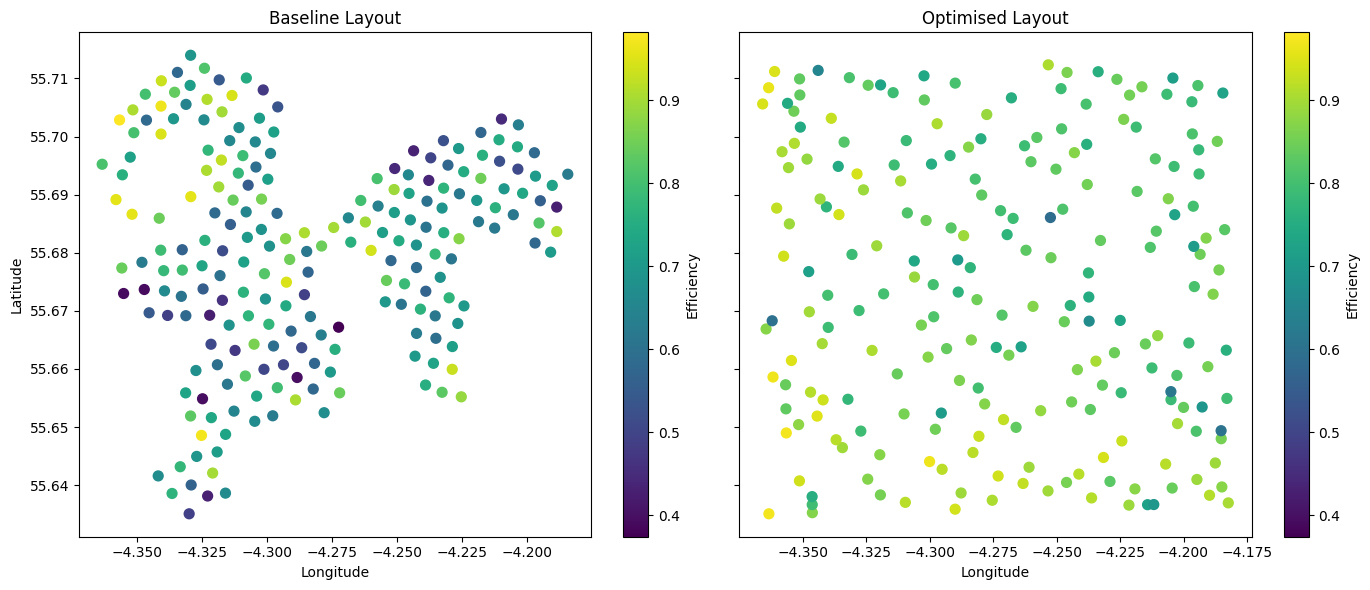

In [12]:
# Assuming turbine_loc, turbine_eff, optimised_loc, and optimised_eff are already defined
# turbine_loc and optimised_loc should be lists of (x, y) tuples
# turbine_eff and optimised_eff should be lists of efficiency values

# Extract x and y coordinates for baseline and optimized layouts
baseline_y, baseline_x = zip(*turbine_loc)
optimised_y, optimised_x = zip(*optimised_loc)

# Determine the global efficiency range for consistent colormap scaling
eff_min = min(min(turbine_eff), min(optimised_eff))
eff_max = max(max(turbine_eff), max(optimised_eff))

# Create the scatterplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Baseline layout scatterplot
scatter1 = axes[0].scatter(baseline_x, baseline_y, c=turbine_eff, cmap='viridis', s=50, vmin=eff_min, vmax=eff_max)
axes[0].set_title('Baseline Layout')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(scatter1, ax=axes[0], label='Efficiency')

# Optimized layout scatterplot
scatter2 = axes[1].scatter(optimised_x, optimised_y, c=optimised_eff, cmap='viridis', s=50, vmin=eff_min, vmax=eff_max)
axes[1].set_title('Optimised Layout')
axes[1].set_xlabel('Longitude')
fig.colorbar(scatter2, ax=axes[1], label='Efficiency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

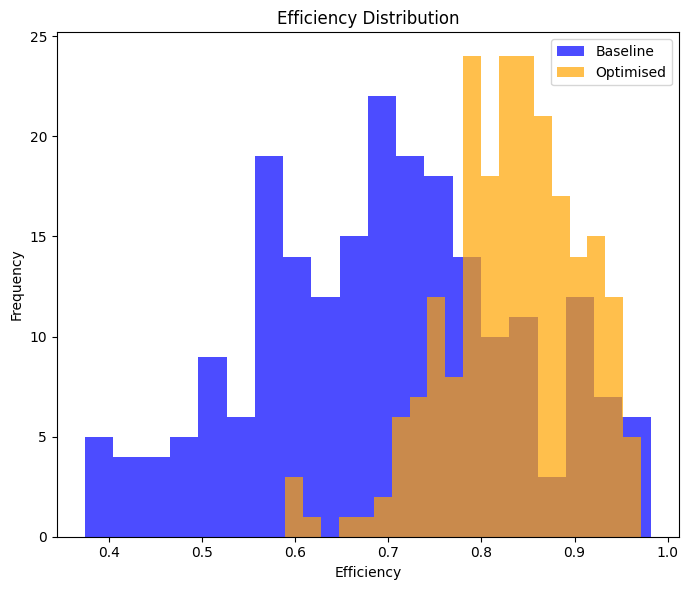

In [13]:
# Assuming turbine_loc, turbine_eff, optimised_loc, and optimised_eff are already defined
# turbine_loc and optimised_loc should be lists of (x, y) tuples
# turbine_eff and optimised_eff should be lists of efficiency values

# Extract x and y coordinates for baseline and optimized layouts
baseline_y, baseline_x = zip(*turbine_loc)
optimised_y, optimised_x = zip(*optimised_loc)

# Determine the global efficiency range for consistent colormap scaling
eff_min = min(min(turbine_eff), min(optimised_eff))
eff_max = max(max(turbine_eff), max(optimised_eff))

# Create the scatterplots and histogram
fig = plt.figure(figsize=(7, 6))

# Histogram for efficiency distribution
ax3 = fig.add_subplot(1, 1, 1)
ax3.hist(turbine_eff, bins=20, alpha=0.7, label='Baseline', color='blue')
ax3.hist(optimised_eff, bins=20, alpha=0.7, label='Optimised', color='orange')
ax3.set_title('Efficiency Distribution')
ax3.set_xlabel('Efficiency')
ax3.set_ylabel('Frequency')
ax3.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()